In [1]:
import numpy as np
import datetime
import tensorflow as tf
from library.models import Generator,Discriminator
from library.losses import discriminator_loss,generator_loss
from library.dataset import load_mnist

# GAN

In [2]:
class Generative_Adverserial_Nets:
    def __init__(self,dataset,image_shape=(28,28,1),noise_dim=100,batch_size=256):
        
        self.image_shape=image_shape
        self.noise_dim=noise_dim
        self.batch_size=batch_size   
        self.buffer_size=60000
        self.num_of_batchs=dataset.shape[0]//self.batch_size
        self.dataset=tf.data.Dataset.from_tensor_slices(dataset).shuffle(self.buffer_size).batch(self.batch_size,
                                                                                                 drop_remainder=True)
        
        self.G=Generator(self.noise_dim)
        self.D=Discriminator(self.image_shape)

        self.G_optim=tf.keras.optimizers.Adam(1e-4)
        self.D_optim=tf.keras.optimizers.Adam(1e-4)
        
        
        self.current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = 'logs/VGAN/' + self.current_time
        self.summary_writer = tf.summary.create_file_writer(self.log_dir)
        
        self.epoch=0 #trained for epoch epochs
        
    @tf.function
    def sample_noise(self,batch_size):
        #return tf.random.normal(shape=(batch_size,self.noise_dim))
        return tf.random.uniform(shape=(batch_size,self.noise_dim),minval=-np.sqrt(3),maxval=+np.sqrt(3))
        
    #@tf.function
    def train_for_1_step(self,images):
        D_LOSS=0
        with tf.GradientTape() as t1:
            z=self.sample_noise(self.batch_size)
            x=images
            d_loss=discriminator_loss(self.D,self.G,x,z)
            D_LOSS+=d_loss.numpy()
        d_grads=t1.gradient(d_loss,self.D.trainable_variables)
        self.D_optim.apply_gradients(zip(d_grads,self.D.trainable_variables))

        G_LOSS=0
        with tf.GradientTape() as t2:
            z=self.sample_noise(self.batch_size)
            g_loss=generator_loss(self.D,self.G,z)
            G_LOSS+=g_loss.numpy()
        g_grads=t2.gradient(g_loss,self.G.trainable_variables)
        self.G_optim.apply_gradients(zip(g_grads,self.G.trainable_variables))

        return D_LOSS,G_LOSS
    
    
    def train(self,epochs=50,log_epoch=1):
        while self.epoch<epochs:
            D_LOSS=0;G_LOSS=0
            for images in self.dataset:
                d_loss,g_loss=self.train_for_1_step(images)
                D_LOSS+=d_loss;G_LOSS+=g_loss
                
            D_LOSS/=self.num_of_batchs
            G_LOSS/=self.num_of_batchs
            
            if self.epoch%log_epoch==0:
                with self.summary_writer.as_default():
                    tf.summary.scalar('loss/Generator', G_LOSS, step=self.epoch)
                    tf.summary.scalar('loss/Discriminator', D_LOSS, step=self.epoch)
                
            self.epoch+=1

In [3]:
gan=Generative_Adverserial_Nets(load_mnist(),image_shape=(28,28,1),noise_dim=100,batch_size=256)

In [4]:
gan.train(epochs=100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Generate

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

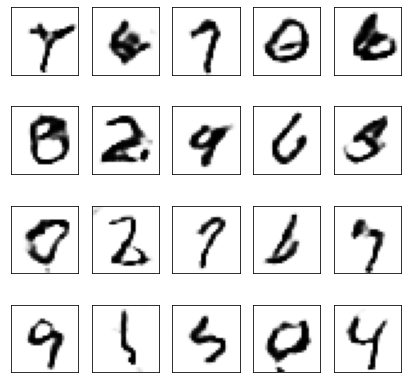

In [26]:
img=gan.G.predict(gan.sample_noise(20))
fig=plt.figure(figsize=(7,7))
for row in range(4):
    for col in range(5):
        ax=fig.add_subplot(4,5,5*row+col+1)
        ax.imshow(img[5*row+col].reshape(28,28),cmap='gray_r')
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

In [27]:
tf.sigmoid(gan.D(img,training=False))

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[0.3902275 ],
       [0.29161936],
       [0.2931844 ],
       [0.40903327],
       [0.55995363],
       [0.1875122 ],
       [0.47449455],
       [0.44862628],
       [0.5503261 ],
       [0.42803293],
       [0.28280598],
       [0.62586856],
       [0.49448502],
       [0.33950225],
       [0.2860852 ],
       [0.33013257],
       [0.48832887],
       [0.4142286 ],
       [0.35533676],
       [0.5579379 ]], dtype=float32)>